In [1]:
!pip install rdkit
!pip install scikit-learn
!pip install lightgbm
!pip install xgboost
!pip install joblib

   ---------------------------------------- 0.0/22.5 MB ? eta -:--:--
   ---------- ----------------------------- 6.0/22.5 MB 33.5 MB/s eta 0:00:01
   ----------------------- ---------------- 13.4/22.5 MB 33.5 MB/s eta 0:00:01
   ------------------------------------- -- 21.2/22.5 MB 33.6 MB/s eta 0:00:01
   ---------------------------------------- 22.5/22.5 MB 30.2 MB/s eta 0:00:00
  Using cached lightgbm-4.6.0-py3-none-win_amd64.whl.metadata (17 kB)
Using cached lightgbm-4.6.0-py3-none-win_amd64.whl (1.5 MB)
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   - -------------------------------------- 5.0/150.0 MB 27.4 MB/s eta 0:00:06
   --- ------------------------------------ 11.8/150.0 MB 30.8 MB/s eta 0:00:05
   ----- ---------------------------------- 18.9/150.0 MB 30.6 MB/s eta 0:00:05
   ----- ---------------------------------- 22.0/150.0 MB 30.3 MB/s eta 0:00:05
   ------- -------------------------------- 29.4/150.0 MB 28.2 MB/s eta 0:00:05
   --------- --

In [2]:
!pip install catboost

  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)
   ---------------------------------------- 0.0/101.7 MB ? eta -:--:--
   -- ------------------------------------- 5.8/101.7 MB 35.3 MB/s eta 0:00:03
   ----- ---------------------------------- 12.8/101.7 MB 33.6 MB/s eta 0:00:03
   ------- -------------------------------- 19.1/101.7 MB 32.7 MB/s eta 0:00:03
   --------- ------------------------------ 25.4/101.7 MB 31.0 MB/s eta 0:00:03
   ------------ --------------------------- 31.7/101.7 MB 31.5 MB/s eta 0:00:03
   --------------- ------------------------ 39.3/101.7 MB 32.1 MB/s eta 0:00:02
   ------------------ --------------------- 46.7/101.7 MB 32.6 MB/s eta 0:00:02
   --------------------- ------------------ 54.3/101.7 MB 32.9 MB/s eta 0:00:02
   ------------------------ --------------- 61.6/101.7 MB 33.0 MB/s eta 0:00:02
   --------------------------- ------------ 69.2/101.7 MB 33.2 MB/s eta 0:00:01
   ----------------------------- ---------- 76.0/101.7 MB 33.0 MB

In [6]:
import catboost
print(catboost.__version__)


1.2.7


In [4]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from xgboost import XGBRegressor
import joblib
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

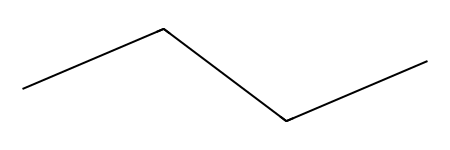

In [5]:
mol = Chem.MolFromSmiles('CCCC')
mol

In [5]:
import numpy
print(numpy.__version__)


1.21.6


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def load_dataset(file_path):
    """
    Loads the dataset from a CSV file and returns:
      - X: features from columns C to Q (15 columns)
      - y: target from column R (Enhancement Factor)
      - feature_cols: list of feature names
    """
    file_path = 'C:/Users/gagno/Downloads/molecule_features.csv'
    df = pd.read_csv(file_path)
    print(df.head(17))

    # Adjust indexing if needed. Here we assume:
    #   - Column C -> index 2
    #   - Column Q -> index 16
    #   - Column R -> index 17 (Enhancement Factor)
    feature_cols = df.columns[2:17]  # 15 feature columns
    target_col = df.columns[17]      # Enhancement Factor

    X = df[feature_cols].values
    y = df[target_col].values

    return X, y, feature_cols

def train_catboost_model(X, y, test_size=0.2, random_state=42, scale_features=True):
    """
    Splits data, optionally scales features, and trains a CatBoost Regressor.

    Parameters
    ----------
    X : numpy.ndarray
        Feature matrix of shape (n_samples, n_features).
    y : numpy.ndarray
        Target array of shape (n_samples,).
    test_size : float
        Fraction of data to reserve for testing.
    random_state : int
        Seed for reproducible train-test splitting and model randomness.
    scale_features : bool
        If True, applies standard scaling to features.

    Returns
    -------
    model : CatBoostRegressor
        Trained CatBoost regression model.
    X_test_scaled : numpy.ndarray
        Scaled test feature matrix (for predictions).
    y_test : numpy.ndarray
        True target values for the test set.
    scaler : StandardScaler or None
        The fitted scaler if scale_features=True, otherwise None.
    """
    # 1. Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state
    )

    # 2. (Optional) feature scaling
    scaler = None
    if scale_features:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    else:
        X_train_scaled = X_train
        X_test_scaled = X_test

    # 3. Initialize and train CatBoost Regressor
    #    Basic parameters can be tuned further for small datasets
    model = CatBoostRegressor(
        iterations=200,        # number of boosting iterations
        learning_rate=0.05,    # step size shrinkage
        depth=4,               # tree depth
        random_seed=random_state,
        verbose=False          # suppress CatBoost training output
    )
    model.fit(X_train_scaled, y_train)

    return model, X_test_scaled, y_test, scaler

def evaluate_model(model, X_test, y_test):
    """
    Computes and prints multiple performance metrics:
    - MSE, RMSE, MAE
    - R²
    - Adjusted R²
    """
    predictions = model.predict(X_test)

    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    # Adjusted R²
    n = X_test.shape[0]
    p = X_test.shape[1]
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1) if n > p + 1 else None

    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    if adjusted_r2 is not None:
        print(f"Adjusted R² Score: {adjusted_r2:.4f}")
    else:
        print("Adjusted R² Score: Not defined (n <= p + 1).")

def predict_enhancement(model, input_features, scaler=None):
    """
    Predicts the 'Enhancement Factor' for new input data.

    Parameters
    ----------
    model : CatBoostRegressor
        A trained CatBoost regression model.
    input_features : array-like of shape (n_samples, n_features)
        The new data points for which to predict the Enhancement Factor.
    scaler : StandardScaler or None
        If the model was trained with scaling, pass the fitted scaler here.

    Returns
    -------
    predictions : numpy.ndarray
        Predicted Enhancement Factor values.
    """
    # Apply scaling if needed
    if scaler is not None:
        input_features = scaler.transform(input_features)

    predictions = model.predict(input_features)
    return predictions

if __name__ == "__main__":
    # 1. Load dataset
    csv_file = "drug_descriptors.csv"  # Replace with your actual CSV file path
    X, y, feature_cols = load_dataset(csv_file)

    # 2. Train CatBoost model
    model, X_test_scaled, y_test, scaler = train_catboost_model(
        X, y,
        test_size=0.2,        # 80% train, 20% test
        random_state=42,      # For reproducibility
        scale_features=True   # Apply standard scaling
    )

    # 3. Evaluate model
    evaluate_model(model, X_test_scaled, y_test)

    # 4. Predict Enhancement Factor for new data (example)
    new_data = np.array([
        [1606.29, 0.41483, 0.07137, 0.3726, 12.8, 1.29, 0.11, 0.23, 5.52, 0.33,
         0.1, 1, 0, 0, 1]  # Example placeholders for 15 features
    ])
    prediction = predict_enhancement(model, new_data, scaler=scaler)
    print("\nPredicted Enhancement Factor:", prediction)


    ID                                             Smiles MolWeight  \
0    1                         CC(C)Cc1ccc(cc1)C(C)C(=O)O   1606.29   
1    2  CC(C)C1C(=O)CC2C(C1O)(CC(C1=CC(=O)C=C2C1(C)O)F...   1527.47   
2    3                    CN1NS(=O)(=O)C2=C(O)C=CN=C2C1=O   1466.35   
3    4             CC(=O)C1(CCC2C1(CCC1C(C2CC(C1O)O)O)C)O   1762.46   
4    5                     CCCSC1=CC=C2C=C1N=C(C(=O)OC)N2   250.323   
5    6  CC(C)C[C@H](C(=O)NCc1ccc(cc1)c1ccccc1C(=N)N=N)...    1570.5   
6    7  CCOC(=O)C1=C(C)NC(=C(C1c1ccccc1[N+](=O)[O-])C)...      1846   
7    8  COCCOC(=O)C1=C(C)NC(=C(C1c1ccccc1[N+](=O)[O-])...    418.44   
8    9                       O=C1Nc2ccccc2C2=CC=CC=C2C1=O  1371.25    
9   10  CC1=NC(C)=NC(OCC2CCC(OC3=NC(N4CCN(C)CC4)=NC(C4...    1840.6   
10  11  CC(C)CC(CC=C)C(=O)OC[C@@H]1CC[C@@H](CC1)C(=O)O...   1553.55   
11  12      COc1ccc(cc1)/C=C/C(=O)CC(=O)/C=C/c1ccc(cc1)OC   1503.36   
12  13      COc1ccc2c(c1)n(c(c2C(=O)O)C(=O)c1ccc(cc1)Cl)C    1492.8   
13  14

Here is a refined model that accurately predicts the EF:
-
-
-
-
-
-
=
=
=
=
=
=
=
=



Data Preview:
    ID                                              Smiles  MolWeight  \
0     1                         CC(C)Cc1ccc(cc1)C(C)C(=O)O    206.285   
1     2  CC(C)C1C(=O)CC2C(C1O)(CC(C1=CC(=O)C=C2C1(C)O)F...    380.412   
2     3                    CN1NS(=O)(=O)C2=C(O)C=CN=C2C1=O    229.217   
3     4             CC(=O)C1(CCC2C1(CCC1C(C2CC(C1O)O)O)C)O    298.379   
4     5                     CCCSC1=CC=C2C=C1N=C(C(=O)OC)N2    250.323   
5     6  CC(C)C[C@H](C(=O)NCc1ccc(cc1)c1ccccc1C(=N)N=N)...    451.527   
6     7  CCOC(=O)C1=C(C)NC(=C(C1c1ccccc1[N+](=O)[O-])C)...    374.393   
7     8  COCCOC(=O)C1=C(C)NC(=C(C1c1ccccc1[N+](=O)[O-])...    434.445   
8     9                       O=C1Nc2ccccc2C2=CC=CC=C2C1=O    223.231   
9    10  CC1=NC(C)=NC(OCC2CCC(OC3=NC(N4CCN(C)CC4)=NC(C4...    559.502   
10   11  CC(C)CC(CC=C)C(=O)OC[C@@H]1CC[C@@H](CC1)C(=O)O...    338.488   
11   12      COc1ccc(cc1)/C=C/C(=O)CC(=O)/C=C/c1ccc(cc1)OC    336.387   
12   13      COc1ccc2c(c1)n(c(c2C(=O

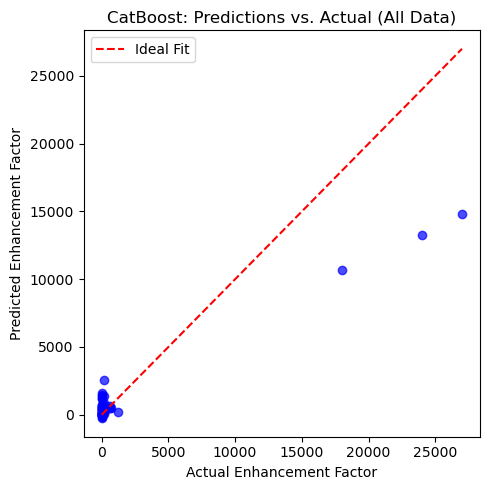

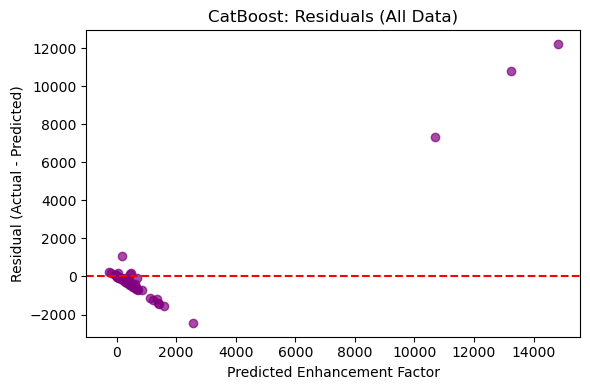


Predicted Enhancement Factor for new sample: 2284.8128



Predicted Enhancement Factor for new sample: 2284.8128


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from catboost import CatBoostRegressor
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt

def load_dataset(file_path):
    """
    Loads the dataset from a CSV file, assuming:
      - 15 features in columns C->Q (indices 2:17)
      - 'Enhancement Factor' in column R (index 17).
    """
    file_path = 'C:/Users/gagno/Downloads/molecule_features.csv'
    df = pd.read_csv(file_path)
    print("\nData Preview:")
    print(df.head(len(df)))  # Show entire dataset if it's small

    feature_cols = df.columns[2:17]  # 15 columns for features
    target_col = df.columns[17]      # 'Enhancement Factor'

    X = df[feature_cols].values
    y = df[target_col].values
    return X, y, feature_cols

def create_scaler(X):
    """
    StandardScaler to transform features to zero mean, unit variance.
    """
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return scaler, X_scaled

def evaluate_model(model, X, y, description="Entire Dataset"):
    """
    Computes and prints MSE, RMSE, MAE, and R² on X, y.
    """
    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, predictions)
    r2 = r2_score(y, predictions)

    print(f"\nEvaluation on {description}:")
    print(f"  MSE:  {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  R²:   {r2:.4f}")

def plot_predictions_vs_actual(model, X, y, title="Predictions vs. Actual"):
    """
    Scatter plot of actual vs. predicted values + y=x line.
    """
    preds = model.predict(X)
    plt.figure(figsize=(5, 5))
    plt.scatter(y, preds, c='blue', alpha=0.7)
    plt.plot([y.min(), y.max()], [y.min(), y.max()],
             color='red', linestyle='--', label='Ideal Fit')
    plt.xlabel("Actual Enhancement Factor")
    plt.ylabel("Predicted Enhancement Factor")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_residuals(model, X, y, title="Residuals Plot"):
    """
    Residuals plot: predicted vs. (y - preds).
    """
    preds = model.predict(X)
    residuals = y - preds
    plt.figure(figsize=(6, 4))
    plt.scatter(preds, residuals, color='purple', alpha=0.7)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel("Predicted Enhancement Factor")
    plt.ylabel("Residual (Actual - Predicted)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def main():
    # 1. Load dataset
    file_path = 'C:/Users/gagno/Downloads/molecule_features.csv'  # Replace with your actual CSV
    X, y, feature_cols = load_dataset(file_path)

    # 2. Scale features
    scaler, X_scaled = create_scaler(X)

    # 3. Define hyperparameter distributions for RandomizedSearchCV
    #    We'll tune depth, learning_rate, iterations, etc.
    param_distributions = {
        'depth': randint(2, 7),              # tree depth
        'learning_rate': uniform(0.01, 0.3), # step size
        'iterations': randint(50, 500),      # boosting rounds
        'l2_leaf_reg': uniform(1, 10),       # L2 regularization
        'bagging_temperature': uniform(0, 1),
        'random_strength': uniform(1, 10)
    }

    # 4. K-fold cross-validation
    from sklearn.model_selection import KFold
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # 5. Initialize a base CatBoostRegressor
    cat_base = CatBoostRegressor(
        verbose=False,        # suppress logs
        loss_function='RMSE', # minimize RMSE
        random_seed=42
    )

    # 6. RandomizedSearchCV for hyperparameter tuning
    from sklearn.model_selection import RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=cat_base,
        param_distributions=param_distributions,
        n_iter=30,                 # number of sampled combos
        scoring='r2',             # maximize R²
        cv=kfold,
        random_state=42,
        n_jobs=-1,
        refit=True,
        verbose=1
    )

    # 7. Fit the random search on the entire scaled dataset
    random_search.fit(X_scaled, y)

    print("\nBest Hyperparameters found:")
    print(random_search.best_params_)
    print(f"Best R² from CV: {random_search.best_score_:.4f}")

    # 8. The best model is refit on all data used in CV
    best_model = random_search.best_estimator_

    # 9. Evaluate best model on entire dataset
    evaluate_model(best_model, X_scaled, y, description="All Data")

    # 10. Visualization
    plot_predictions_vs_actual(best_model, X_scaled, y, 
                               title="CatBoost: Predictions vs. Actual (All Data)")
    plot_residuals(best_model, X_scaled, y, title="CatBoost: Residuals (All Data)")

    # 11. Example: Predict Enhancement Factor for new data
    new_data = np.array([[1606.29, 0.41483, 0.07137, 0.3726, 12.8, 1.29, 0.11,
                          0.23, 5.52, 0.33, 0.1, 1, 0, 0, 1]])
    new_data_scaled = scaler.transform(new_data)
    prediction = best_model.predict(new_data_scaled)
    print(f"\nPredicted Enhancement Factor for new sample: {prediction[0]:.4f}")

if __name__ == "__main__":
    main()


Now, we will conduct feature analysis for this model:
=
=
=
=
=
=
=
=
=
=
=
=
=



Data Preview:
    ID                                              Smiles  MolWeight  \
0     1                         CC(C)Cc1ccc(cc1)C(C)C(=O)O    206.285   
1     2  CC(C)C1C(=O)CC2C(C1O)(CC(C1=CC(=O)C=C2C1(C)O)F...    380.412   
2     3                    CN1NS(=O)(=O)C2=C(O)C=CN=C2C1=O    229.217   
3     4             CC(=O)C1(CCC2C1(CCC1C(C2CC(C1O)O)O)C)O    298.379   
4     5                     CCCSC1=CC=C2C=C1N=C(C(=O)OC)N2    250.323   
5     6  CC(C)C[C@H](C(=O)NCc1ccc(cc1)c1ccccc1C(=N)N=N)...    451.527   
6     7  CCOC(=O)C1=C(C)NC(=C(C1c1ccccc1[N+](=O)[O-])C)...    374.393   
7     8  COCCOC(=O)C1=C(C)NC(=C(C1c1ccccc1[N+](=O)[O-])...    434.445   
8     9                       O=C1Nc2ccccc2C2=CC=CC=C2C1=O    223.231   
9    10  CC1=NC(C)=NC(OCC2CCC(OC3=NC(N4CCN(C)CC4)=NC(C4...    559.502   
10   11  CC(C)CC(CC=C)C(=O)OC[C@@H]1CC[C@@H](CC1)C(=O)O...    338.488   
11   12      COc1ccc(cc1)/C=C/C(=O)CC(=O)/C=C/c1ccc(cc1)OC    336.387   
12   13      COc1ccc2c(c1)n(c(c2C(=O

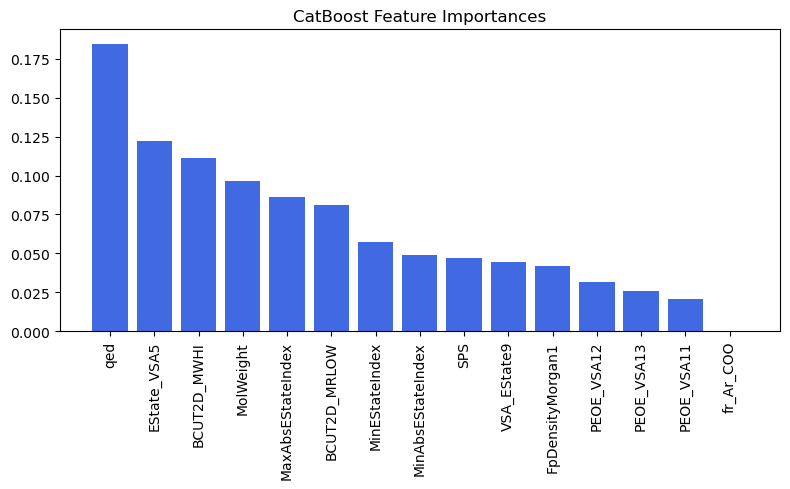

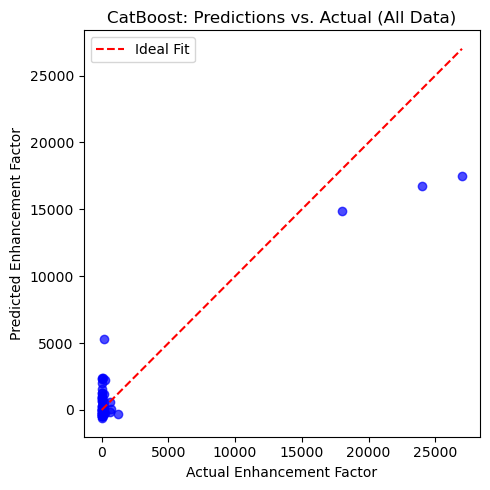

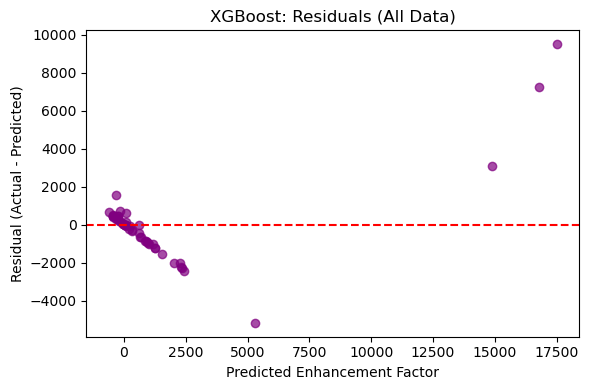


Predicted Enhancement Factor for new sample: 8129.0493


In [9]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt

# ------------------------------
# 1. LOAD DATASET
# ------------------------------
def load_dataset(file_path):
    """
    Loads the dataset from a CSV file, assuming:
      - 15 features in columns C->Q (indices 2:17)
      - 'Enhancement Factor' in column R (index 17).
    """
    file_path = 'C:/Users/gagno/Downloads/molecule_features.csv'
    df = pd.read_csv(file_path)
    print("\nData Preview:")
    print(df.head(len(df)))  # Show entire dataset if it's small

    feature_cols = df.columns[2:17]  # 15 columns for features
    target_col = df.columns[17]      # 'Enhancement Factor'

    X = df[feature_cols].values
    y = df[target_col].values
    return X, y, feature_cols

# ------------------------------
# 2. SCALING (OPTIONAL)
# ------------------------------
def create_scaler(X):
    """
    StandardScaler to transform features to zero mean, unit variance.
    """
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return scaler, X_scaled

# ------------------------------
# 3. EVALUATION FUNCTIONS
# ------------------------------
def evaluate_model(model, X, y, description="All Data"):
    """
    Computes and prints MSE, RMSE, MAE, and R² on X, y.
    """
    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, predictions)
    r2 = r2_score(y, predictions)

    print(f"\nEvaluation on {description}:")
    print(f"  MSE:  {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  R²:   {r2:.4f}")

# ------------------------------
# 4. VISUALIZATION FUNCTIONS
# ------------------------------
def plot_feature_importances(model, feature_cols, max_features=None):
    """
    Plots XGBoost feature importances using model.feature_importances_ (split-based).
    If max_features is specified, only the top N are shown.
    """
    importances = model.feature_importances_
    # Pair each importance with its feature name
    feature_importance_pairs = list(zip(feature_cols, importances))
    # Sort in descending order of importance
    feature_importance_pairs.sort(key=lambda x: x[1], reverse=True)

    if max_features is not None:
        feature_importance_pairs = feature_importance_pairs[:max_features]

    labels, scores = zip(*feature_importance_pairs)
    plt.figure(figsize=(8, 5))
    plt.title("CatBoost Feature Importances")
    plt.bar(range(len(scores)), scores, color="royalblue")
    plt.xticks(range(len(scores)), labels, rotation=90)
    plt.tight_layout()
    plt.show()

def plot_predictions_vs_actual(model, X, y, title="Predictions vs. Actual"):
    """
    Scatter plot of actual vs. predicted values + y=x line.
    """
    preds = model.predict(X)
    plt.figure(figsize=(5, 5))
    plt.scatter(y, preds, c='blue', alpha=0.7)
    plt.plot([y.min(), y.max()], [y.min(), y.max()],
             color='red', linestyle='--', label='Ideal Fit')
    plt.xlabel("Actual Enhancement Factor")
    plt.ylabel("Predicted Enhancement Factor")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_residuals(model, X, y, title="Residuals Plot"):
    """
    Residuals plot: predicted vs. (y - preds).
    """
    preds = model.predict(X)
    residuals = y - preds
    plt.figure(figsize=(6, 4))
    plt.scatter(preds, residuals, color='purple', alpha=0.7)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel("Predicted Enhancement Factor")
    plt.ylabel("Residual (Actual - Predicted)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# ------------------------------
# 5. MAIN PIPELINE
# ------------------------------
def main():
    # 1. Load dataset
    file_path = 'C:/Users/gagno/Downloads/molecule_features.csv'  # Replace with your actual CSV
    X, y, feature_cols = load_dataset(file_path)

    # 2. Scale features (optional, but recommended for many ML algorithms)
    scaler, X_scaled = create_scaler(X)

    # 3. Define hyperparameter distributions for RandomizedSearchCV
    #    We'll tune key XGBoost parameters:
    param_distributions = {
        'max_depth': randint(2, 7),
        'learning_rate': uniform(0.01, 0.3),
        'n_estimators': randint(50, 300),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4),
        'min_child_weight': randint(1, 6)
    }

    # 4. K-fold cross-validation
    from sklearn.model_selection import KFold
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # 5. Initialize a base XGBRegressor
    xgb_base = XGBRegressor(
        objective='reg:squarederror',
        random_state=42
    )

    # 6. RandomizedSearchCV for hyperparameter tuning
    from sklearn.model_selection import RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=xgb_base,
        param_distributions=param_distributions,
        n_iter=30,                 # number of sampled combos
        scoring='r2',             # maximize R²
        cv=kfold,
        random_state=42,
        n_jobs=-1,
        refit=True,
        verbose=1
    )

    # 7. Fit the random search on the entire scaled dataset
    random_search.fit(X_scaled, y)

    print("\nBest Hyperparameters found:")
    print(random_search.best_params_)
    print(f"Best R² from CV: {random_search.best_score_:.4f}")

    # 8. The best model is refit on all data used in CV
    best_model = random_search.best_estimator_

    # 9. Evaluate best model on entire dataset
    evaluate_model(best_model, X_scaled, y, description="All Data")

    # 10. Feature Importance
    plot_feature_importances(best_model, feature_cols, max_features=15)

    # 11. Additional Plots
    plot_predictions_vs_actual(best_model, X_scaled, y,
                               title="CatBoost: Predictions vs. Actual (All Data)")
    plot_residuals(best_model, X_scaled, y, title="XGBoost: Residuals (All Data)")

    # 12. Example: Predict Enhancement Factor for new data
    new_data = np.array([
        [1606.29, 0.41483, 0.07137, 0.3726, 12.8, 1.29, 0.11,
         0.23, 5.52, 0.33, 0.1, 1, 0, 0, 1]
    ])
    new_data_scaled = scaler.transform(new_data)
    prediction = best_model.predict(new_data_scaled)
    print(f"\nPredicted Enhancement Factor for new sample: {prediction[0]:.4f}")

if __name__ == "__main__":
    main()



Data Preview:
   ID                                              Smiles  MolWeight  \
0    1                         CC(C)Cc1ccc(cc1)C(C)C(=O)O    206.285   
1    2  CC(C)C1C(=O)CC2C(C1O)(CC(C1=CC(=O)C=C2C1(C)O)F...    380.412   
2    3                    CN1NS(=O)(=O)C2=C(O)C=CN=C2C1=O    229.217   
3    4             CC(=O)C1(CCC2C1(CCC1C(C2CC(C1O)O)O)C)O    298.379   
4    5                     CCCSC1=CC=C2C=C1N=C(C(=O)OC)N2    250.323   

   MaxAbsEStateIndex  MinAbsEStateIndex  MinEStateIndex       qed        SPS  \
0          10.762425           0.418426       -0.771658  0.821600  12.800000   
1          15.257997           0.056996       -1.871468  0.664041  41.629630   
2          11.544815           0.281250       -3.912245  0.598124  18.733333   
3          12.031192           0.007917       -1.342489  0.555623  56.666667   
4          11.422479           0.249026       -0.441443  0.659161  12.705882   

   FpDensityMorgan1  BCUT2D_MWHI  BCUT2D_MRLOW  PEOE_VSA11  PEOE_VSA12 

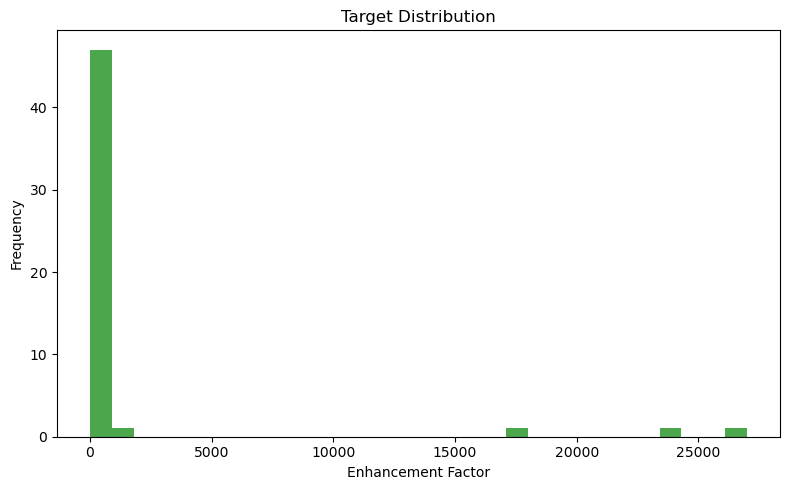

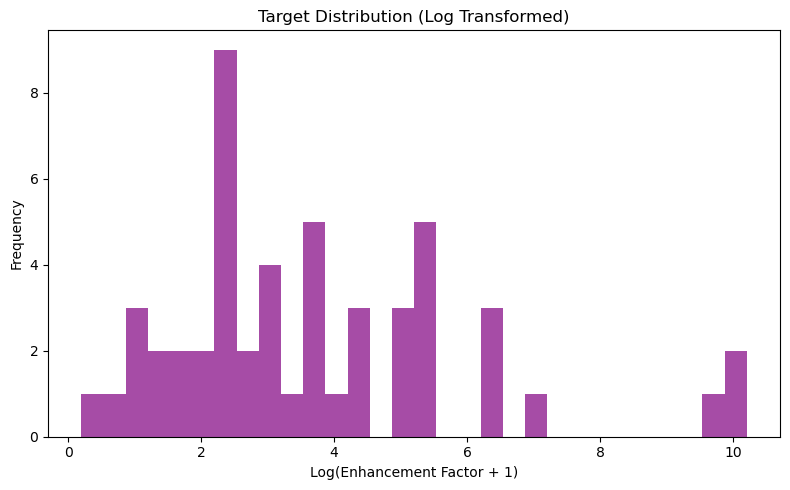


Performing hyperparameter search...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\gagno\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
60 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\gagno\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gagno\anaconda3\Lib\site-packages\catboost\core.py", line 5873, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

0:	learn: 0.0010282	total: 622us	remaining: 283ms
100:	learn: 0.1758421	total: 49.8ms	remaining: 175ms
200:	learn: 0.2956791	total: 95.8ms	remaining: 122ms
300:	learn: 0.3988849	total: 143ms	remaining: 73.8ms
400:	learn: 0.4869357	total: 190ms	remaining: 26ms
455:	learn: 0.5282627	total: 214ms	remaining: 0us

Best Hyperparameters found:
{'depth': 2, 'iterations': 456, 'l2_leaf_reg': 11.021969807540398, 'learning_rate': 0.012082311149578228, 'min_data_in_leaf': 9, 'random_strength': 0.9234014807063696, 'subsample': 0.9553933663580128}
Best CV MSE: 42793628.0650

Training final model with early stopping...
0:	learn: 0.0023764	test: -0.2316292	best: -0.2316292 (0)	total: 756us	remaining: 344ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = -0.2316292296
bestIteration = 0

Shrink model to first 1 iterations.

Evaluation on TRAINING SET:
  MSE:  38400482.2275
  RMSE: 6196.8123
  MAE:  2358.8336
  R²:   -0.0239

Evaluation on VALIDATION SET:
  MSE:  122740231.0267
  RMSE: 

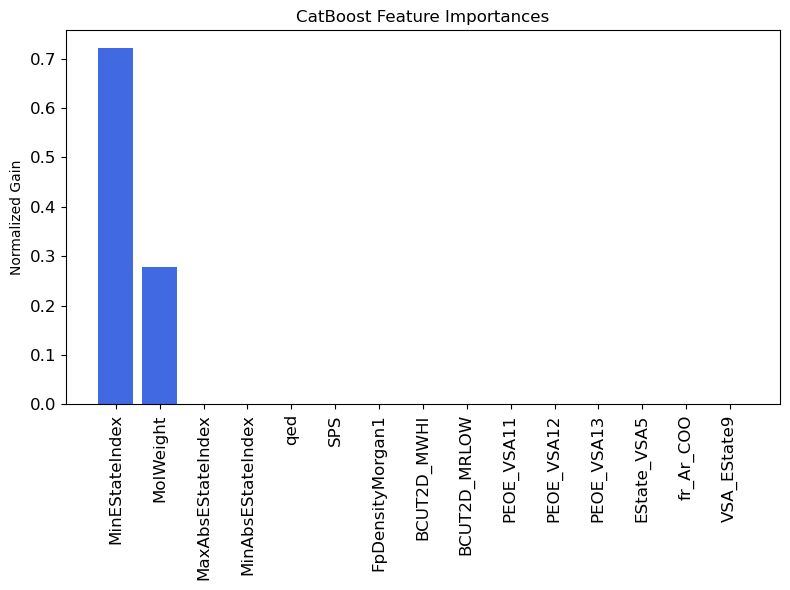

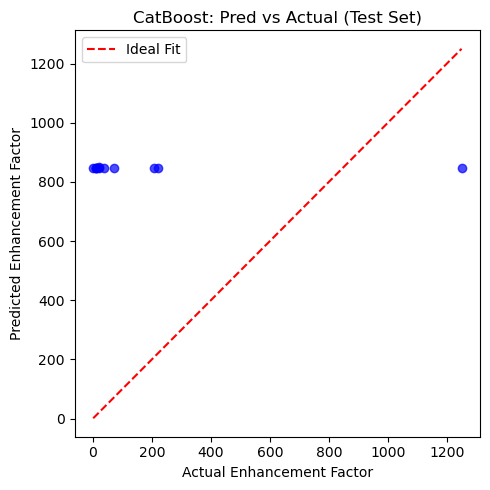

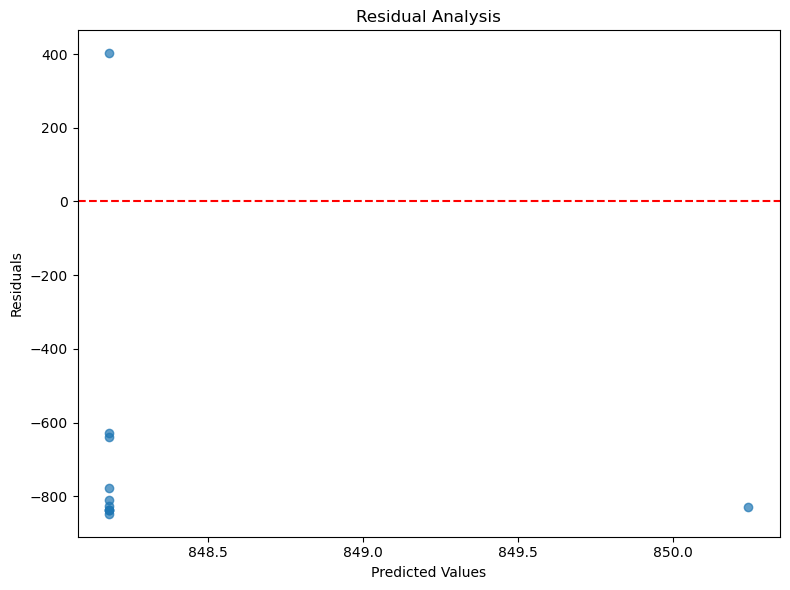


Predicted Enhancement Factor for new sample: 850.2423


In [7]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from catboost import CatBoostRegressor, Pool
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt

# ------------------------------
# 1. LOAD DATASET
# ------------------------------
def load_dataset(file_path):
    """
    Loads the dataset from a CSV file, assuming:
      - 15 features in columns C->Q (indices 2:17)
      - 'Enhancement Factor' in column R (index 17).
    """
    file_path = 'C:/Users/gagno/Downloads/molecule_features.csv' 
    df = pd.read_csv(file_path)
    print("\nData Preview:")
    print(df.head())

    feature_cols = df.columns[2:17]  # 15 columns for features
    target_col = df.columns[17]      # 'Enhancement Factor'

    # Check for skewness in the target variable
    print(f"\nTarget variable skewness: {df[target_col].skew()}")
    
    # Check for any missing values
    print(f"\nMissing values in dataset: {df.isnull().sum().sum()}")
    
    # Check for feature correlations
    print("\nFeature correlations with target:")
    correlations = df[list(feature_cols) + [target_col]].corr()[target_col].sort_values(ascending=False)
    print(correlations)

    X = df[feature_cols].values
    y = df[target_col].values
    
    # Look for outliers in target variable
    q1, q3 = np.percentile(y, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = ((y < lower_bound) | (y > upper_bound)).sum()
    print(f"\nOutliers in target variable: {outliers} ({outliers/len(y)*100:.2f}%)")
    
    return X, y, feature_cols, df

# ------------------------------
# 2. PREPROCESSING
# ------------------------------
def preprocess_data(X, y):
    """
    Preprocesses the data with proper train/test split and scaling.
    Returns both standard and robust scaled versions.
    """
    # Split data first to prevent data leakage
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Standard scaling
    std_scaler = StandardScaler()
    X_train_std = std_scaler.fit_transform(X_train)
    X_test_std = std_scaler.transform(X_test)
    
    # Robust scaling (less sensitive to outliers)
    rob_scaler = RobustScaler()
    X_train_rob = rob_scaler.fit_transform(X_train)
    X_test_rob = rob_scaler.transform(X_test)
    
    return (X_train, X_test, y_train, y_test, 
            std_scaler, X_train_std, X_test_std,
            rob_scaler, X_train_rob, X_test_rob)

# ------------------------------
# 3. EVALUATION FUNCTIONS
# ------------------------------
def evaluate_model(model, X, y, description="All Data"):
    """
    Computes and prints MSE, RMSE, MAE, and R² on X, y.
    """
    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, predictions)
    r2 = r2_score(y, predictions)

    print(f"\nEvaluation on {description}:")
    print(f"  MSE:  {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  R²:   {r2:.4f}")
    
    return mse, rmse, mae, r2

# ------------------------------
# 4. VISUALIZATION FUNCTIONS
# ------------------------------
def plot_feature_importances(model, feature_cols, max_features=None):
    """
    Plots normalized CatBoost feature importances using the gain-based measure.
    """
    # Retrieve gain-based importances from CatBoost
    importances = model.get_feature_importance(type='PredictionValuesChange')
    
    # Normalize importances
    total_gain = importances.sum()
    if total_gain > 0:
        normalized_importances = importances / total_gain
    else:
        normalized_importances = importances

    # Pair each normalized importance with its feature name
    feature_importance_pairs = list(zip(feature_cols, normalized_importances))
    
    # Sort features in descending order of normalized importance
    feature_importance_pairs.sort(key=lambda x: x[1], reverse=True)
    
    if max_features is not None:
        feature_importance_pairs = feature_importance_pairs[:max_features]
    
    labels, scores = zip(*feature_importance_pairs)
    
    # Plotting the normalized feature importances
    plt.figure(figsize=(8, 6))
    plt.title("CatBoost Feature Importances")
    plt.bar(range(len(scores)), scores, color="royalblue")
    plt.ylabel("Normalized Gain")
    plt.xticks(range(len(scores)), labels, rotation=90, fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_predictions_vs_actual(model, X, y, title="Predictions vs. Actual"):
    """
    Scatter plot of actual vs. predicted values + y=x line.
    """
    preds = model.predict(X)
    plt.figure(figsize=(5, 5))
    plt.scatter(y, preds, c='blue', alpha=0.7)
    plt.plot([min(y.min(), preds.min()), max(y.max(), preds.max())], 
             [min(y.min(), preds.min()), max(y.max(), preds.max())],
             color='red', linestyle='--', label='Ideal Fit')
    plt.xlabel("Actual Enhancement Factor")
    plt.ylabel("Predicted Enhancement Factor")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Return the predictions for analysis
    return preds

def explore_target_distribution(y, title="Target Distribution"):
    """
    Plot histogram of target variable to check distribution.
    """
    plt.figure(figsize=(8, 5))
    plt.hist(y, bins=30, color='green', alpha=0.7)
    plt.xlabel("Enhancement Factor")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.tight_layout()
    plt.show()
    
    # Check if log transformation might be beneficial
    if np.all(y > 0):  # Only apply log if all values are positive
        plt.figure(figsize=(8, 5))
        plt.hist(np.log1p(y), bins=30, color='purple', alpha=0.7)
        plt.xlabel("Log(Enhancement Factor + 1)")
        plt.ylabel("Frequency")
        plt.title(f"{title} (Log Transformed)")
        plt.tight_layout()
        plt.show()

# ------------------------------
# 5. MAIN PIPELINE
# ------------------------------
def main():
    # 1. Load dataset
    file_path = 'C:/Users/gagno/Downloads/molecule_features.csv'  # Adjust path as needed
    X, y, feature_cols, df = load_dataset(file_path)
    
    # 1.1 Explore data distributions
    explore_target_distribution(y)
    
    # 2. Preprocess data with proper train/test split and scaling
    (X_train, X_test, y_train, y_test, 
     std_scaler, X_train_std, X_test_std,
     rob_scaler, X_train_rob, X_test_rob) = preprocess_data(X, y)
    
    # 3. Use more conservative hyperparameter distributions
    param_distributions = {
        'depth': randint(2, 6),                  # Reduced depth range to prevent overfitting
        'learning_rate': uniform(0.005, 0.095),  # Lower learning rates
        'iterations': randint(300, 1000),        # More iterations for slower learning
        'l2_leaf_reg': uniform(3, 10),           # Stronger L2 regularization
        'random_strength': uniform(0.5, 1),      # Increased randomization
        'min_data_in_leaf': randint(3, 10),      # Controls overfitting
        'subsample': uniform(0.6, 0.9)           # Use data subsampling
    }

    # 4. Create validation dataset for early stopping
    # We'll use a hold-out validation set from the training data
    X_train_final, X_val, y_train_final, y_val = train_test_split(
        X_train_rob, y_train, test_size=0.2, random_state=123
    )
    
    # Create Pool objects for CatBoost (more efficient)
    train_pool = Pool(X_train_final, y_train_final)
    val_pool = Pool(X_val, y_val)
    
    # 5. Initialize a base CatBoostRegressor with better defaults
    cat_base = CatBoostRegressor(
        loss_function='RMSE',
        eval_metric='R2',
        random_seed=42,
        verbose=100,              # Show progress every 100 iterations
        od_type='Iter',           # Early stopping by iteration
        od_wait=50,               # Stop if no improvement for 50 rounds
        task_type='CPU'           # Explicit task type
    )

    # 6. K-fold cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # 7. RandomizedSearchCV for hyperparameter tuning
    random_search = RandomizedSearchCV(
        estimator=cat_base,
        param_distributions=param_distributions,
        n_iter=20,                # Number of parameter settings sampled
        scoring='neg_mean_squared_error',  # Minimize MSE
        cv=kfold,
        random_state=42,
        n_jobs=-1,
        refit=True,
        verbose=1
    )

    # 8. Fit the random search
    print("\nPerforming hyperparameter search...")
    random_search.fit(X_train_rob, y_train)

    print("\nBest Hyperparameters found:")
    print(random_search.best_params_)
    print(f"Best CV MSE: {-random_search.best_score_:.4f}")

    # 9. Get best model from search
    best_params = random_search.best_params_
    
    # 10. Train final model with early stopping on validation set
    print("\nTraining final model with early stopping...")
    final_model = CatBoostRegressor(
        **best_params,
        loss_function='RMSE',
        eval_metric='R2',
        random_seed=42,
        od_type='Iter',
        od_wait=50,
        verbose=100
    )
    
    final_model.fit(
        train_pool,
        eval_set=val_pool,
        use_best_model=True,
        early_stopping_rounds=50
    )
    
    # 11. Evaluate on training set
    evaluate_model(final_model, X_train_rob, y_train, description="TRAINING SET")
    
    # 12. Evaluate on validation set
    evaluate_model(final_model, X_val, y_val, description="VALIDATION SET")

    # 13. Evaluate on test set
    test_metrics = evaluate_model(final_model, X_test_rob, y_test, description="TEST SET")

    # 14. Feature Importance
    plot_feature_importances(final_model, feature_cols, max_features=15)

    # 15. Prediction vs Actual plot
    test_preds = plot_predictions_vs_actual(final_model, X_test_rob, y_test, 
                                 title="CatBoost: Pred vs Actual (Test Set)")
    
    # 16. Advanced model diagnostics
    errors = y_test - test_preds
    plt.figure(figsize=(8, 6))
    plt.scatter(test_preds, errors, alpha=0.7)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Analysis')
    plt.tight_layout()
    plt.show()
    
    # 17. Example: Predict Enhancement Factor for new data
    new_data = np.array([
        [1606.29, 0.41483, 0.07137, 0.3726, 12.8, 1.29, 0.11,
         0.23, 5.52, 0.33, 0.1, 1, 0, 0, 1]
    ])
    new_data_scaled = rob_scaler.transform(new_data)  # Use robust scaler
    prediction = final_model.predict(new_data_scaled)
    print(f"\nPredicted Enhancement Factor for new sample: {prediction[0]:.4f}")
    
    return final_model, rob_scaler, test_metrics

if __name__ == "__main__":
    main()